In [1]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
df = pd.read_csv('data/monkey_labels.txt')
df.head()

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26


In [3]:
os.listdir('data/training')

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [4]:
os.listdir('data/training/n0')[:5]

['n0018.jpg', 'n0019.jpg', 'n0020.jpg', 'n0021.jpg', 'n0022.jpg']

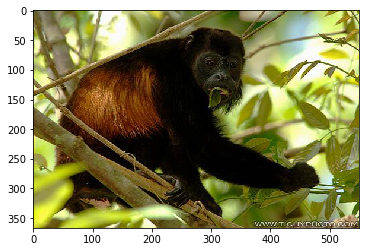

In [5]:
img = plt.imread('data/training/n0/n0018.jpg')
plt.imshow(img)

In [6]:
img.shape

(367, 550, 3)

In [7]:
sz=224
arch=resnet34

In [10]:
data = ImageClassifierData.from_paths('data', tfms=tfms_from_model(arch, sz), trn_name='training',val_name='validation')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                
    0      1.27843    0.270747   0.970588  
    1      0.629165   0.083881   0.988971                  



[array([0.08388]), 0.9889705882352942]

In [11]:
learn.save('1_lastlayer')

In [12]:
learn.load('1_lastlayer')

In [13]:
data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [14]:
learn.unfreeze()

In [15]:
lr=np.array([1e-4,1e-3,1e-2])

In [16]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.144917   0.085694   0.981618  
    1      0.136795   0.070813   0.988971                  
    2      0.127463   0.069624   0.988971                  



[array([0.06962]), 0.9889705882352942]

In [17]:
learn.save('2_lastlayer')

In [18]:
learn.load('2_lastlayer')

In [19]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [20]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 3, replace=False)

In [21]:
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

In [22]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [23]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [24]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

Correctly classified


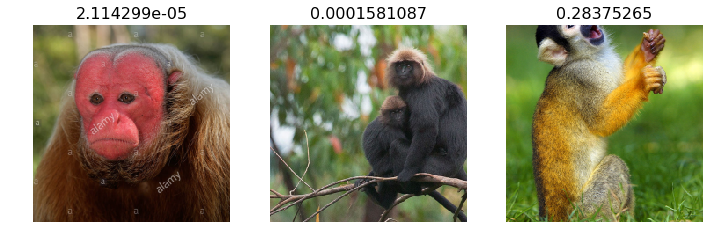

In [25]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [26]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

Incorrectly classified


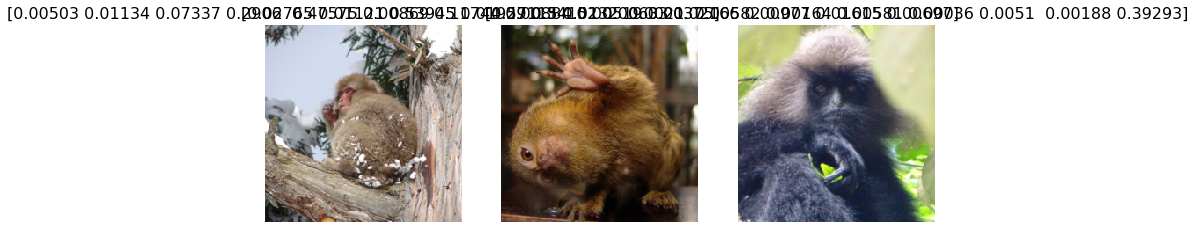

In [27]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y, preds)

0.9889705882352942

### Accuracy: 98.89%